In [255]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
import numpy as np
from numpy.typing import NDArray
import scipy.signal
from matplotlib import pyplot as plt

from channel import Splitter, SSFChannel
from filters import CDCompensator, PulseFilter
from frequency_recovery import FrequencyRecovery
from laser import NoisyLaser
from modulation import (
    Demodulator16QAM,
    DemodulatorQPSK,
    IQModulator,
    Modulator16QAM,
    ModulatorQPSK,
)
from phase_recovery import DecisionDirected
from receiver import Digital90degHybrid, HeterodyneFrontEnd

In [257]:
CHANNEL_SPS = 16
RECEIVER_SPS = 2
# At Eb/N0 = 10 dB, we need around 49 taps at 25 km, 79 taps at 50 km, and 143
# taps at 100 km. However, we can go up to 2**n - 1 without increasing the
# overlap-save frame size, which should be strictly better.
CDC_TAPS = 63
FIBRE_LENGTH = 25_000  # 25 km
SPLITTING_POINT = 24_000  # 24 km
CONSUMERS = 64
SYMBOL_RATE = 50 * 10**9  # 50 GS/s
TARGET_BER = 0.5 * 10**-3
DDPR_BUFFER_SIZE = 64
LASER_LINEWIDTH_ESTIMATE = 100e3  # 100 kHz
SNR_ESTIMATE = 10  # 10 dB
# Paper uses 60,000 QPSK training symbols
LENGTH = PulseFilter.symbols_for_total_length(2**16)

In [258]:
def plot_signal(signal: np.ndarray) -> None:
    assert signal.ndim == 1
    assert signal.size > 0

    s_real = np.real(signal[:8192])
    s_imag = np.imag(signal[:8192])

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

    # Constellation diagram.
    ax = axs[0][0]
    ax.scatter(s_real, s_imag, alpha=0.05)
    ax.axis("equal")
    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.axhline(color="black")
    ax.axvline(color="black")

    # Unused plot.
    axs[1][0].set_axis_off()

    # Signal (real component).
    ax = axs[0][1]
    ax.stem(s_real)
    ax.set_xlim(-4, 512)
    ax.set_xlabel("Sample")
    ax.set_ylabel("In-phase")

    # Signal (imaginary component).
    ax = axs[1][1]
    ax.stem(s_imag)
    ax.set_xlim(-4, 512)
    ax.set_xlabel("Sample")
    ax.set_ylabel("Quadrature")

    # Spectrum.
    axs[0][2].magnitude_spectrum(signal.tolist(), sides="twosided")
    axs[1][2].phase_spectrum(signal.tolist(), sides="twosided")

    fig.tight_layout()

    plt.show()

In [259]:
def find_lag(ref: NDArray[np.bool_], sig: NDArray[np.bool_]) -> int:
    corr = scipy.signal.correlate(ref.astype(np.float64), sig.astype(np.float64))
    lags = scipy.signal.correlation_lags(ref.size, sig.size)

    lag = lags[np.argmax(corr)]

    return lag


def compare_streams(
    ref: NDArray[np.bool_], sig: NDArray[np.bool_]
) -> tuple[float, float]:
    # Ensure lag + y.size < x.size.
    sig_slice = sig[:-10_000] if sig.size > ref.size - 10_000 else sig

    # Both polarizations carry the same data, but one stream is delayed by 98
    # symbols (196 bits). Unfortunately, this isn't always the case.
    lag = find_lag(ref, sig_slice)
    assert lag >= 0

    ref_slice = ref[lag : lag + sig_slice.size]
    assert ref_slice.size == sig_slice.size

    ber = np.count_nonzero(ref_slice ^ sig_slice) / ref_slice.size

    return lag, ber

In [260]:
# Generate and modulate data.
data = np.random.randint(0, 2, LENGTH * Modulator16QAM.bits_per_symbol, np.bool_)

tx_mod = Modulator16QAM()(data)

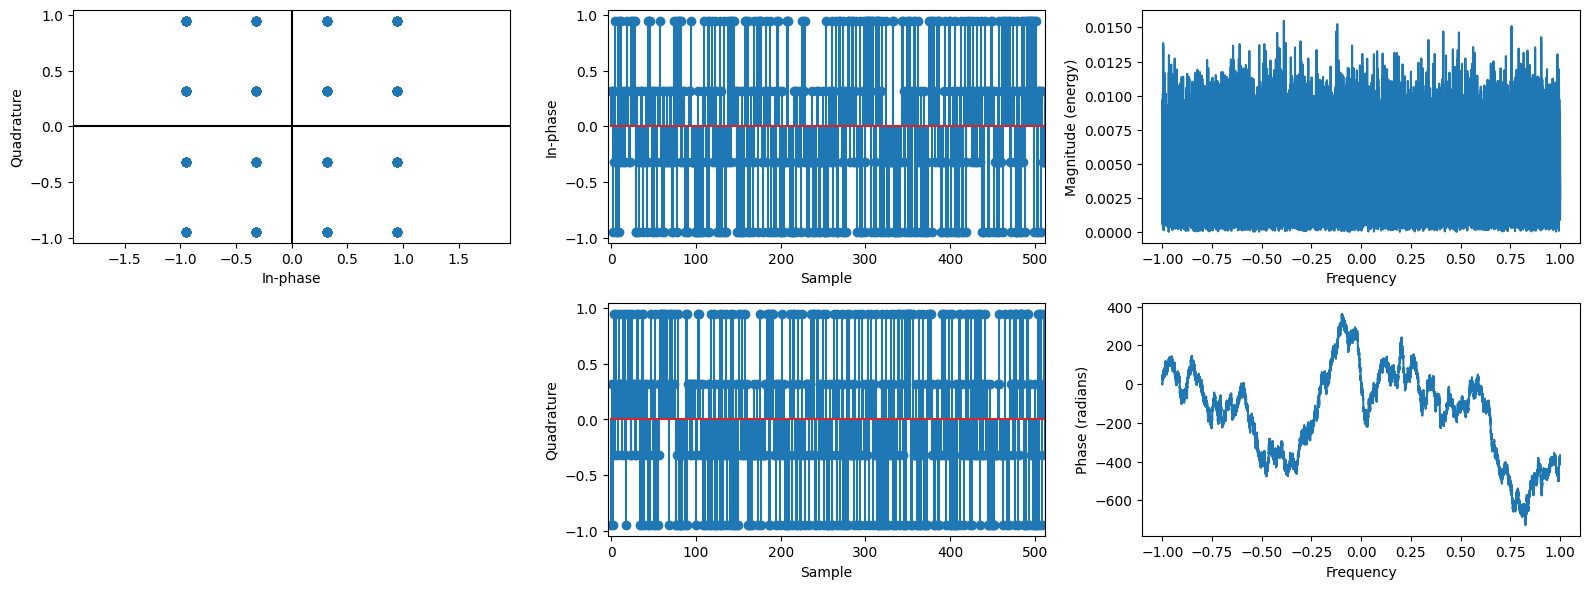

In [261]:
plot_signal(tx_mod)

In [262]:
# Pulse-shaping filter.
tx_pf = PulseFilter(CHANNEL_SPS, up=CHANNEL_SPS)(tx_mod)

In [263]:
tx_pf.shape

(1048576,)

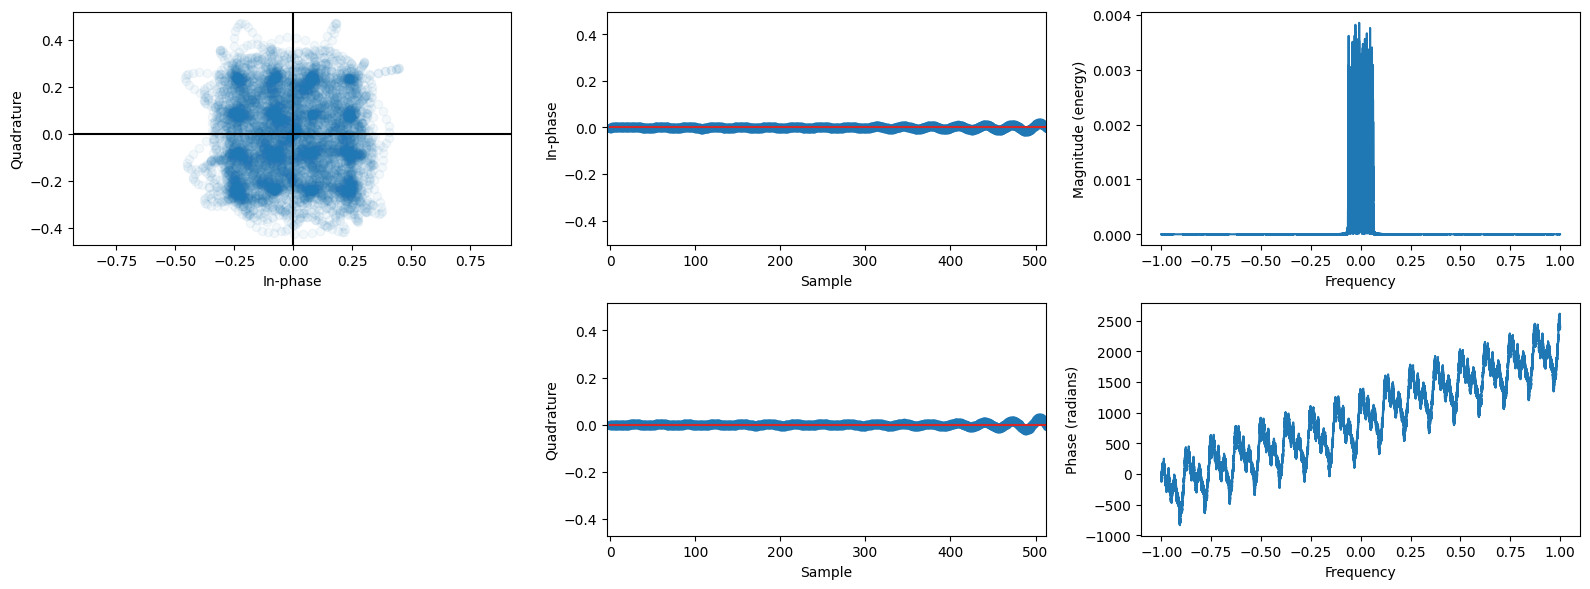

In [264]:
plot_signal(tx_pf)

In [265]:
# Modulate laser.
laser = NoisyLaser(8, SYMBOL_RATE * CHANNEL_SPS)
tx_txd = IQModulator(laser)(tx_pf)

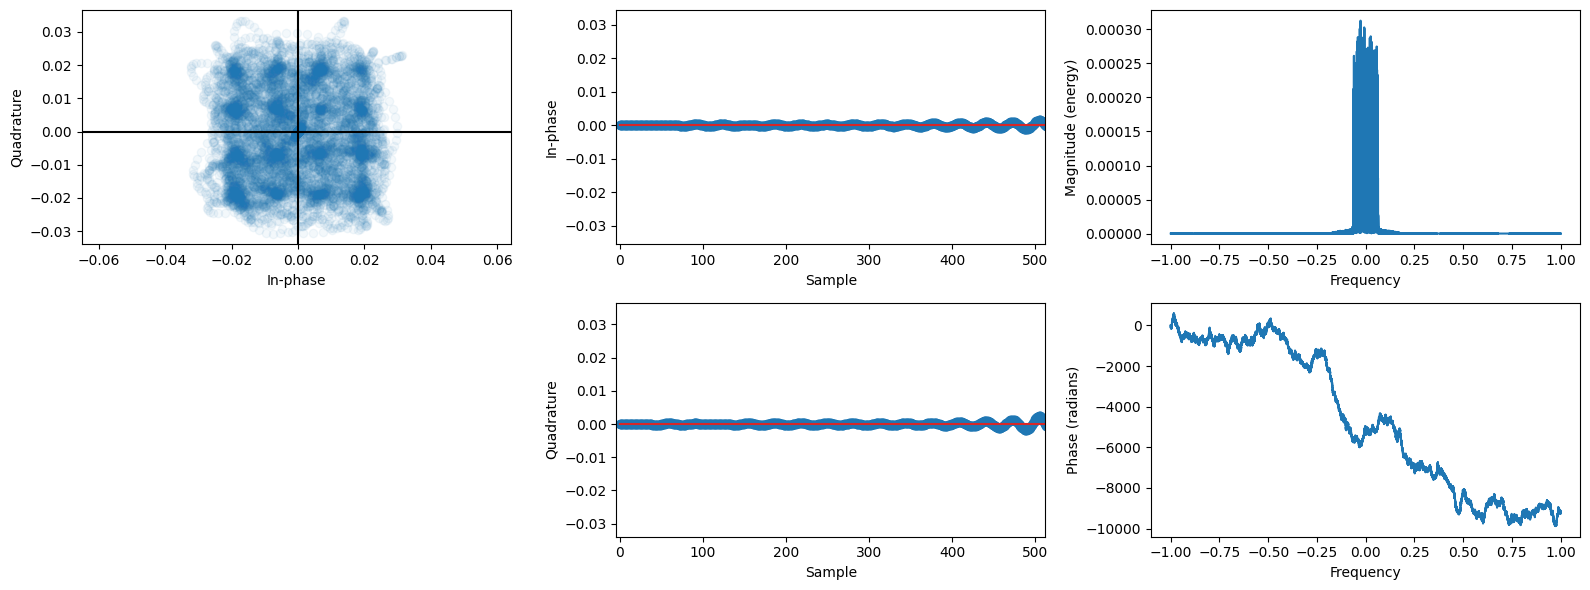

In [266]:
plot_signal(tx_txd)

In [267]:
tx_txd.size // 2

524288

In [268]:
# Simulate channel.
ch_1 = SSFChannel(SPLITTING_POINT, SYMBOL_RATE * CHANNEL_SPS)(tx_txd)
ch_s = Splitter(CONSUMERS)(ch_1)
ch_2 = SSFChannel(FIBRE_LENGTH - SPLITTING_POINT, SYMBOL_RATE * CHANNEL_SPS)(ch_s)

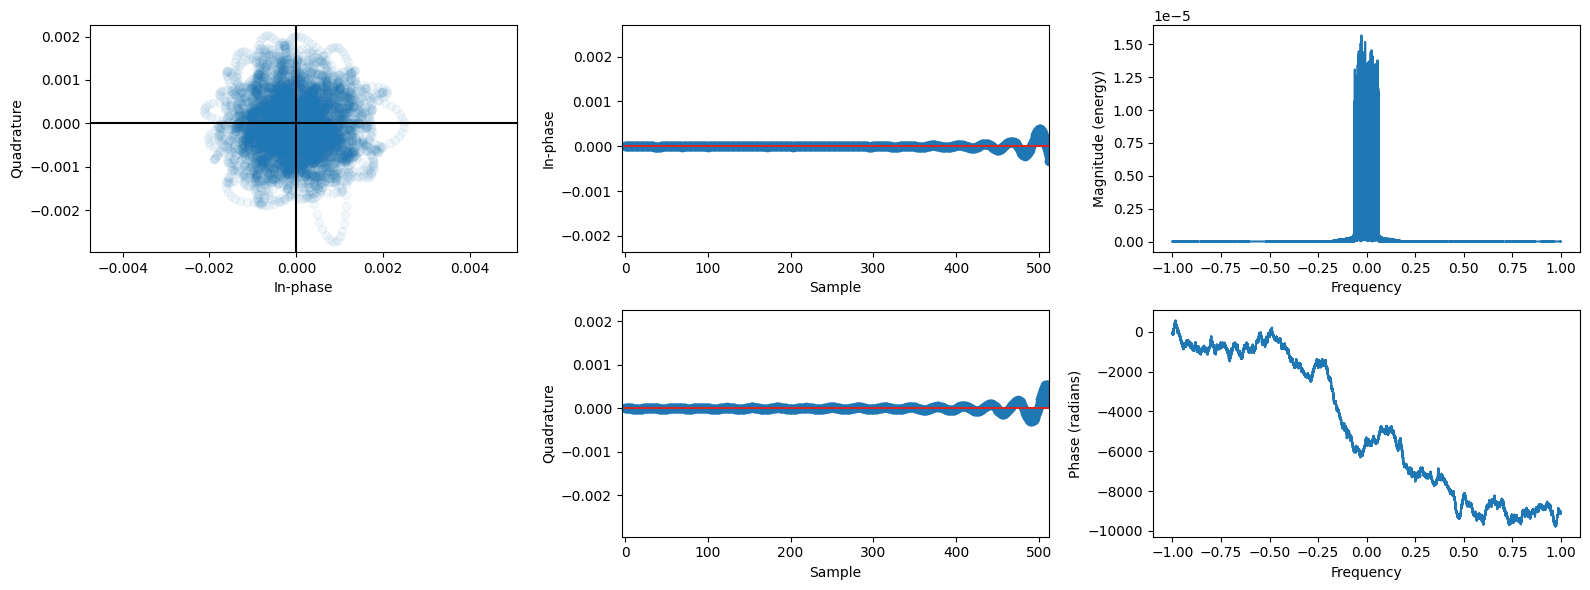

In [269]:
plot_signal(ch_2)

In [270]:
# Heterodyne detector.
rx_fe = HeterodyneFrontEnd(25.2, SYMBOL_RATE * CHANNEL_SPS)(ch_2)

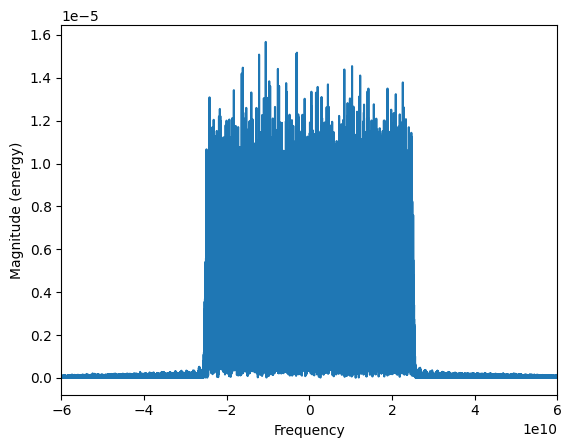

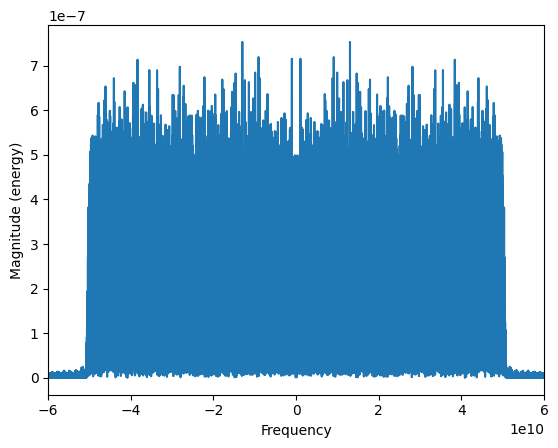

In [271]:
# Real signal, therefore the spectrum is conjugate symmetric.
plt.magnitude_spectrum(ch_2.tolist(), Fs=SYMBOL_RATE * CHANNEL_SPS)
plt.xlim(-60e9, 60e9);
plt.show()
plt.magnitude_spectrum(rx_fe.tolist(), Fs=SYMBOL_RATE * CHANNEL_SPS)
plt.xlim(-60e9, 60e9);

In [352]:
# Design Butterworth IIR filter. You could implement this with analog
# electronics if you had opamps with sufficient bandwidth.
# XXX we filter with sosfiltfilt, so the filter order is doubled.
iirfilt = scipy.signal.butter(4, 65e9, analog=False, output="sos", fs=CHANNEL_SPS * SYMBOL_RATE)

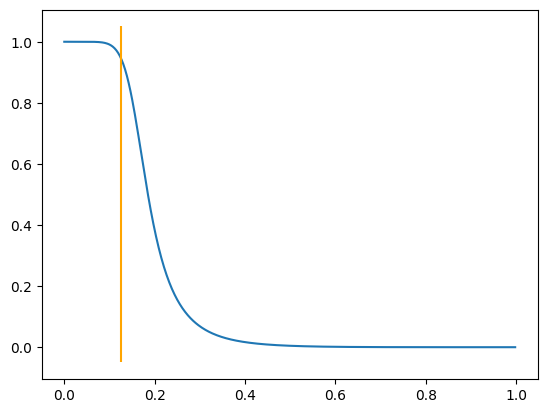

In [351]:
w, h = scipy.signal.sosfreqz(iirfilt)
plt.plot(w/np.pi, np.abs(h))
plt.vlines(0.125, *plt.ylim(), color="orange");

In [330]:
rx_filt = scipy.signal.sosfiltfilt(iirfilt, rx_fe)[::CHANNEL_SPS // RECEIVER_SPS]

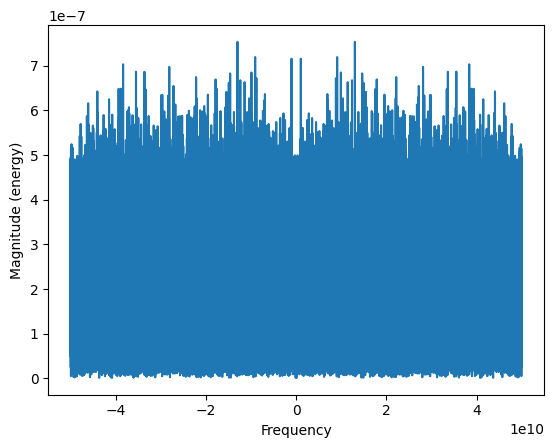

In [331]:
plt.magnitude_spectrum(rx_filt.tolist(), Fs=SYMBOL_RATE * RECEIVER_SPS);

In [334]:
# Translate spectrum to the left by 25.1 GHz.
rx_hybrid = Digital90degHybrid(25.1, SYMBOL_RATE * RECEIVER_SPS)(rx_filt)

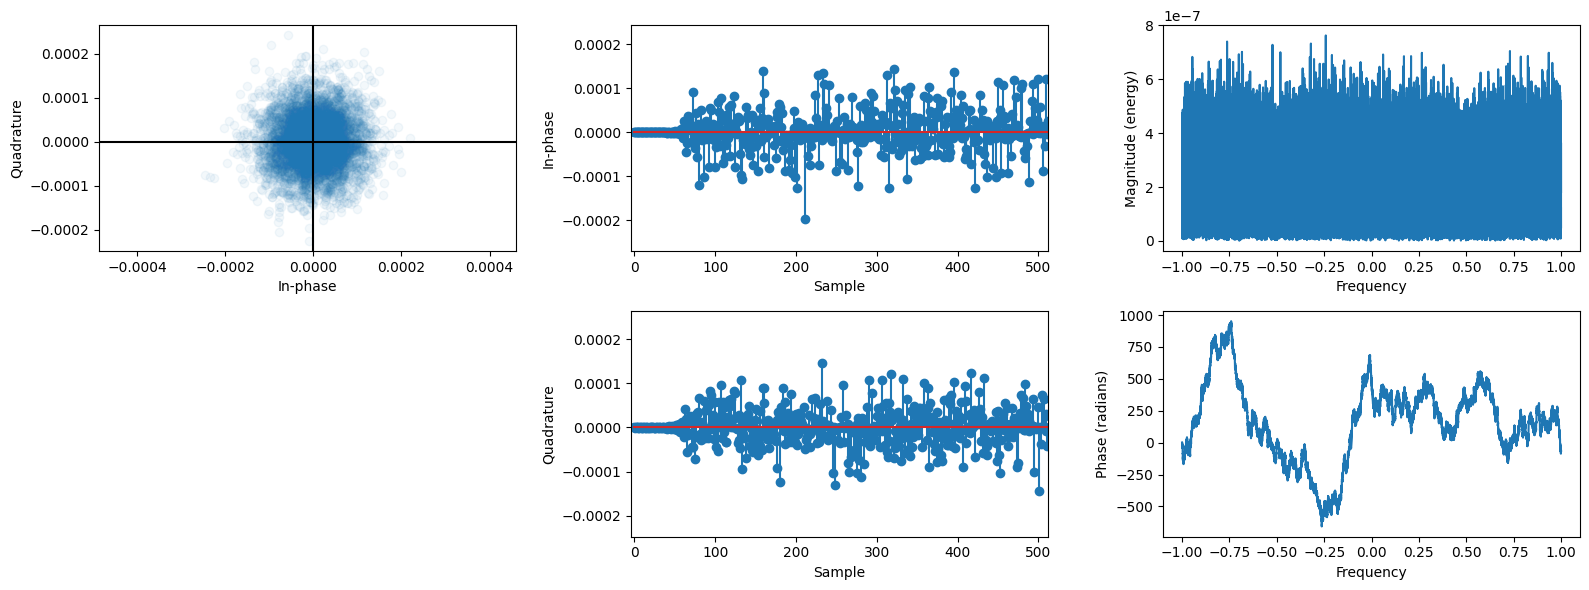

In [335]:
plot_signal(rx_hybrid)

In [340]:
# Filters out what's left from the ex-negative frequencies.
rx_cdc = CDCompensator(FIBRE_LENGTH, SYMBOL_RATE * RECEIVER_SPS, RECEIVER_SPS, CDC_TAPS)(rx_hybrid)

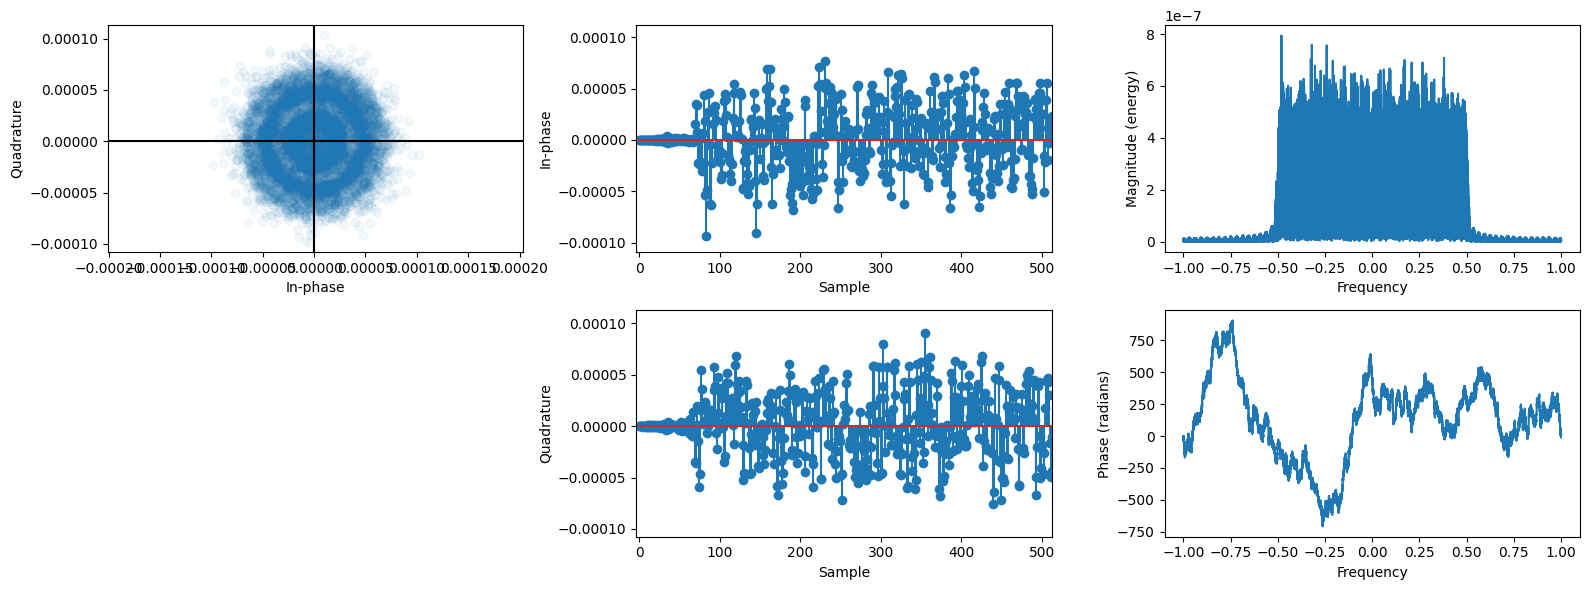

In [341]:
plot_signal(rx_cdc)

In [342]:
fr = FrequencyRecovery(SYMBOL_RATE * RECEIVER_SPS)
rx_fr = fr(rx_cdc)

assert fr.freq_estimate is not None
print(f"{fr.freq_estimate/1e6:.3f} MHz")

100.517 MHz


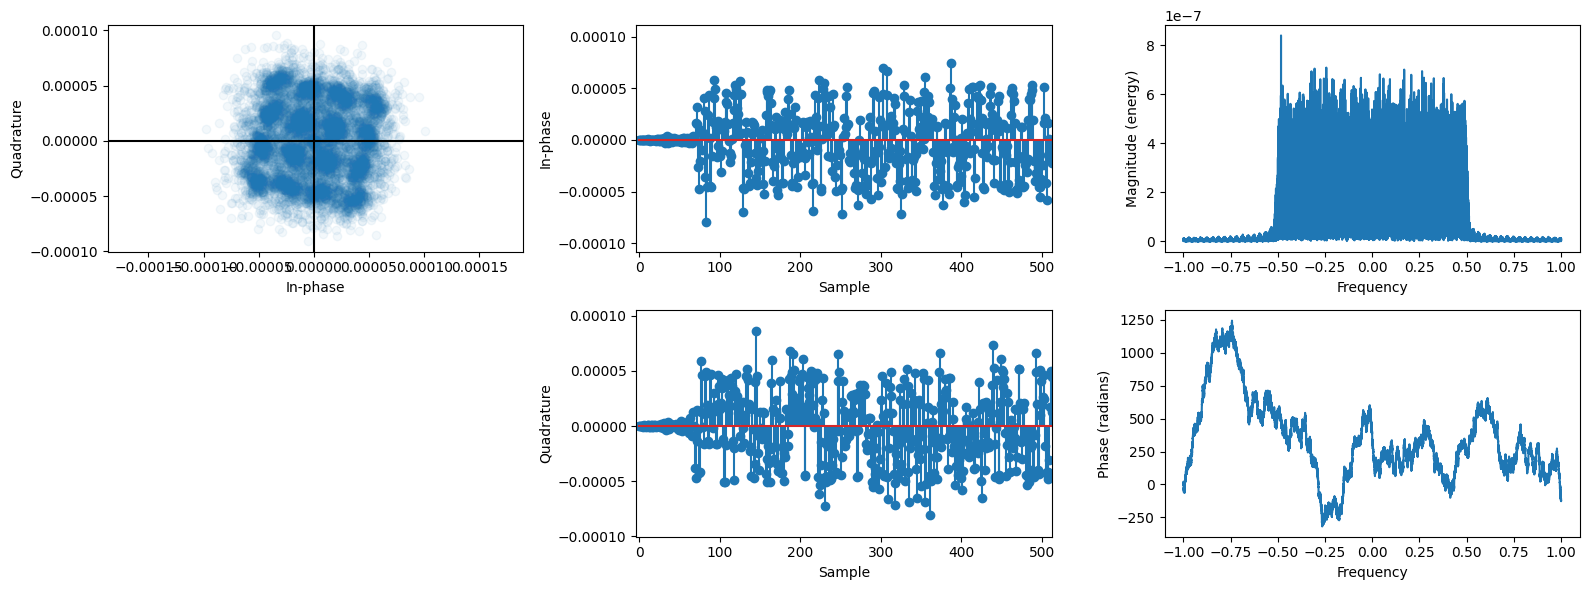

In [343]:
plot_signal(rx_fr)

In [344]:
# Need 1 SpS for Decision-Directed phase recovery.
rx_pf = PulseFilter(RECEIVER_SPS, down=RECEIVER_SPS)(rx_fr)

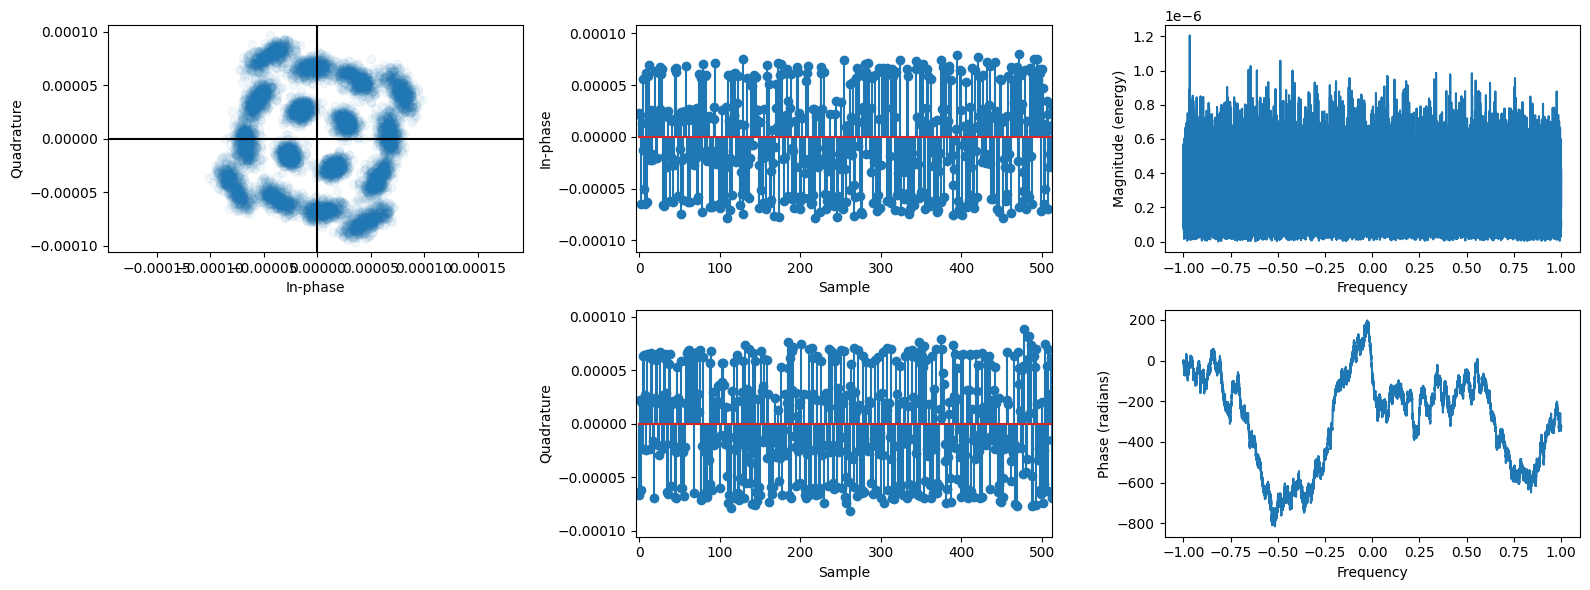

In [345]:
plot_signal(rx_pf)

In [348]:
rx_demod = DecisionDirected(Modulator16QAM(), Demodulator16QAM(), DDPR_BUFFER_SIZE, SYMBOL_RATE, 500e3, 10)(rx_pf)
assert data.size == rx_demod.size

In [349]:
compare_streams(data, rx_demod)

(0, 0.0001746946813410199)